In [0]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.dates as mdates
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Masking

from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG


# Initial Data Importation and Structuring

## Accessing and loading data from Google Drive 



In [2]:
# mounting Google Drive which contains the relevant data

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [30]:
# Fundamental input data
ltm_book = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_book.csv')
ltm_div = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_div.csv')
ltm_ebit = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_ebit.csv')
ltm_ebitda = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_ebitda.csv')
ltm_eps = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_eps.csv')
ltm_fcf = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_fcf.csv')
ltm_pbook = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_pbook.csv')
ltm_sales = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ltm_sales.csv')

ntm_book = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_book.csv')
ntm_div = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_div.csv')
ntm_ebit = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_ebit.csv')
ntm_ebitda = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_ebitda.csv')
ntm_eps = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_eps.csv')
ntm_fcf = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_fcf.csv')
ntm_pbook = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_pbook.csv')
ntm_sales = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/ntm_sales.csv')

# Technical input data

price_high = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/price_high.csv')
price_low = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/price_low.csv')
price_open = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/price_open.csv')
volume = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/volume.csv')
enterprise_val = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/enterprise_val.csv')

print(ltm_book.head())
print("**************************************")
print(ltm_book.info())
print("**************************************")
print(ntm_book.head())
print("**************************************")
print(ntm_book.info())


# Price target output data

price_close = pd.read_csv('/content/drive/My Drive/thw116_FYP/data/price_close.csv')

print(price_close.head())
print("**************************************")
print(price_close.info())



# Test data

# test_data = pd.read_csv("/content/drive/My Drive/thw116_FYP/data/test_price.csv")

# print(test_data.head())
# print("**************************************")
# print(test_data.info())



   Unnamed: 0  ATRS AV  ESSR LN  ...  FABGB SS  926002Q GY  NDA SS
0           1      NaN      NaN  ...       NaN         NaN     NaN
1           2      NaN      NaN  ...       NaN         NaN     NaN
2           3      NaN      NaN  ...       NaN         NaN     NaN
3           4      NaN      NaN  ...       NaN         NaN     NaN
4           5      NaN      NaN  ...       NaN         NaN     NaN

[5 rows x 1185 columns]
**************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6313 entries, 0 to 6312
Columns: 1185 entries, Unnamed: 0 to NDA SS
dtypes: float64(1184), int64(1)
memory usage: 57.1 MB
None
**************************************
   Unnamed: 0  ATRS AV  ESSR LN  ...  FABGB SS  926002Q GY  NDA SS
0           1      NaN      NaN  ...       NaN         NaN     NaN
1           2      NaN      NaN  ...       NaN         NaN     NaN
2           3      NaN      NaN  ...       NaN         NaN     NaN
3           4      NaN      NaN  ...       NaN    

In [32]:
# Filtering incorrect datasets to suitable company subsets
industrials_subset = price_close.columns.values.tolist()

ltm_inputs = [ltm_book, ltm_div, ltm_ebit, ltm_ebitda, ltm_ebitda, ltm_eps, ltm_fcf, ltm_pbook, ltm_sales] 
ntm_inputs = [ntm_book, ntm_div, ntm_ebit, ntm_ebitda, ntm_ebitda, ntm_eps, ntm_fcf, ntm_pbook, ntm_sales]
tech_inputs = [price_high, price_low, price_open, volume, enterprise_val]

for i in range(0,len(ltm_inputs)):
  ltm_inputs[i] = ltm_inputs[i].loc[:, ltm_inputs[i].columns.str.contains('|'.join(industrials_subset))]
  ltm_inputs[i]['Unnamed: 0'] = price_close['Unnamed: 0']
  ltm_inputs[i].rename( columns={'Unnamed: 0':'Date'}, inplace=True )

for i in range(0,len(ntm_inputs)):
  ntm_inputs[i] = ntm_inputs[i].loc[:, ntm_inputs[i].columns.str.contains('|'.join(industrials_subset))]
  ntm_inputs[i]['Unnamed: 0'] = price_close['Unnamed: 0']
  ntm_inputs[i].rename( columns={'Unnamed: 0':'Date'}, inplace=True )

for i in range(0,len(tech_inputs)):
  tech_inputs[i] = tech_inputs[i].loc[:, tech_inputs[i].columns.str.contains('|'.join(industrials_subset))]
  tech_inputs[i]['Unnamed: 0'] = price_close['Unnamed: 0']
  tech_inputs[i].rename( columns={'Unnamed: 0':'Date'}, inplace=True )

  
price_close.rename( columns={'Unnamed: 0':'Date'}, inplace=True )


  
print((ltm_inputs[1].head()))
  



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

         Date  PAYS LN  CNHI IM  SGSN SW  ...  AMS SM  FER SM  SEV FP  FKI LN
0  1995-01-03      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
1  1995-01-04      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
2  1995-01-05      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
3  1995-01-06      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
4  1995-01-09      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN

[5 rows x 204 columns]


## Data Wrangling

In order to produce a dataframe suitable for the model, we must first take the raw *Price.csv*  file and convert it to returns. This can then be maniuplated further in a variety of ways to achieve the neccessary classification for variants of the model

In [33]:
# Conversion of TimeAndDate column to DatetimeIndex for ease of use

def time_index_generator(dataframe):
  dataframe['Date'] = pd.to_datetime(dataframe['Date'], dayfirst=True)
  dataframe.set_index('Date', inplace=True)


for i in range(0,len(ltm_inputs)):
  time_index_generator(ltm_inputs[i])
for i in range(0,len(ntm_inputs)):
  time_index_generator(ntm_inputs[i])
for i in range(0,len(tech_inputs)):
  time_index_generator(tech_inputs[i])  

time_index_generator(price_close)
  
print(ltm_inputs[0].head())
print(ntm_inputs[0].head())
print(tech_inputs[0].head())


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


            PAYS LN  CNHI IM  SGSN SW  PAGE LN  ...  AMS SM  FER SM  SEV FP  FKI LN
Date                                            ...                                
1995-01-03      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
1995-01-04      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
1995-01-05      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
1995-01-06      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
1995-01-09      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN

[5 rows x 203 columns]
            PAYS LN  CNHI IM  SGSN SW  PAGE LN  ...  AMS SM  FER SM  SEV FP  FKI LN
Date                                            ...                                
1995-01-03      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
1995-01-04      NaN      NaN      NaN      NaN  ...     NaN     NaN     NaN     NaN
1995-01-05      NaN      NaN      NaN      NaN  ... 

In [23]:
print(ltm_inputs[0].columns.difference(price_close.columns))
print(ltm_inputs[1].columns.difference(price_close.columns))
print(ltm_inputs[2].columns.difference(price_close.columns))
print(ltm_inputs[3].columns.difference(price_close.columns))


Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')
Index([], dtype='object')


In [90]:
# Anonoymise Tickers 

# Check that all tickers in the set match

# Helper function to generate ticker list
def ticker_list_generator(num):
  ticker_list = []
  for i in range(0, num):
    ticker_name = 'Ticker ' + str(i+1)
    ticker_list.append(ticker_name)
  return ticker_list

anon_tickers = ticker_list_generator(len(ltm_inputs[0].columns))

for i in range(0,len(ltm_inputs)):
  ltm_inputs[0].columns = anon_tickers
for i in range(0,len(ntm_inputs)):
  ntm_inputs[0].columns = anon_tickers
for i in range(0,len(tech_inputs)):
  tech_inputs[0].columns = anon_tickers

price_close.columns = anon_tickers

print(ltm_inputs[0].head())

            Ticker 1  Ticker 2  Ticker 3  ...  Ticker 201  Ticker 202  Ticker 203
Date                                      ...                                    
1995-01-03       NaN       NaN       NaN  ...         NaN         NaN         NaN
1995-01-04       NaN       NaN       NaN  ...         NaN         NaN         NaN
1995-01-05       NaN       NaN       NaN  ...         NaN         NaN         NaN
1995-01-06       NaN       NaN       NaN  ...         NaN         NaN         NaN
1995-01-09       NaN       NaN       NaN  ...         NaN         NaN         NaN

[5 rows x 203 columns]


Text(0, 0.5, 'Attribute')

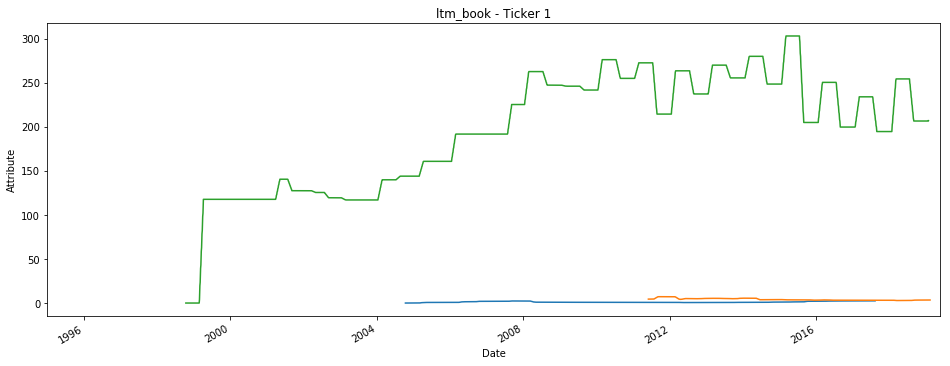

In [36]:
# Selecting a Ticker and plotting

# test_data['Ticker 1'].plot(figsize=(16,6))
# plt.title('Test Results - Ticker 1')
# plt.xlabel('Date')
# plt.ylabel('Attribute')

# test_data.plot(figsize=(16,6))



ltm_inputs[0]['Ticker 1'].plot(figsize=(16,6))
plt.title('ltm_book - Ticker 1')
plt.xlabel('Date')
plt.ylabel('Attribute')

ltm_inputs[0]['Ticker 2'].plot(figsize=(16,6))
plt.title('ltm_book - Ticker 1')
plt.xlabel('Date')
plt.ylabel('Attribute')

ltm_inputs[0]['Ticker 3'].plot(figsize=(16,6))
plt.title('ltm_book - Ticker 1')
plt.xlabel('Date')
plt.ylabel('Attribute')

In [0]:
# Converting Price format to returns format
def price_to_returns(timeframe, dataframe):
  if timeframe == 'daily':
    return dataframe.pct_change(1) # remember to discount all target variables that are NaN
  
  if timeframe == 'monthly':
    return dataframe.resample('BM')
  
returns = price_to_returns('daily', price_close) 

# returns_data = price_to_returns(price_data) 

# Data Preprocessing

Several steps are taken in order to structure the data so that it can be proccessed by the model.

1.   Data Analysis and Cleaning: Data is analysed for missing values, its properties, smoothed for various time intervals and resolved of any inconsistencies.  

2. Training-Test Split: Data is divided into training and test splits according to a selected parameter value. 

3.  Data Transformation: Data is normalised, aggregated and generalised, both for training and testing

4. Data Integration: Data is merged together appropriately to form the input shape of the model.   


##Data Analysis and Cleaning

Something to consider is the fact that returns are more likely to correlate with changes in fundamentals rather than the absolute values of fundamentals. However, there is likely to be a disceprancy in the rate of change of fundamentals and the change in prices. Fundamentals are often only declared quarterly whereas prices are subject to daily fluctuations. We will first analyse the number of times a fundamental changes relative to the price changes. 



In [47]:
def data_change(dataframe, column): 
  noChange_count = 0
  NaN_count = 0
  for i in range (0, len(dataframe.index)): 
    if dataframe[column].diff().iloc[i] == 0:
      noChange_count += 1
    if dataframe[column].isna().iloc[i]: 
      NaN_count += 1
  
  print('Total rows: ', len(dataframe[column]))
  print('The number of rows where no change occurs: ', noChange_count)
  print('The number of rows which are NaN: ', NaN_count)
  print('Useful datapoints:', (len(dataframe[column])-noChange_count-NaN_count))
  
  
print(data_change(ltm_inputs[0], 'Ticker 1'))
print(data_change(ltm_inputs[0], 'Ticker 200'))

print(data_change(ntm_inputs[0], 'Ticker 1'))
print(data_change(ntm_inputs[0], 'Ticker 200'))

print(data_change(tech_inputs[0], 'Ticker 1'))
print(data_change(tech_inputs[0], 'Ticker 200'))
  
  
# # Some tickers are missing so need to account for KeyError
# for i in tickers:
#   try:
#     print(i)
#     data_change(test_data, i)
#   except KeyError:
#     continue


Total rows:  6313
The number of rows where no change occurs:  2659
The number of rows which are NaN:  2992
Useful datapoints: 662
None
Total rows:  6313
The number of rows where no change occurs:  1017
The number of rows which are NaN:  4755
Useful datapoints: 541
None
Total rows:  6313
The number of rows where no change occurs:  1487
The number of rows which are NaN:  3200
Useful datapoints: 1626
None
Total rows:  6313
The number of rows where no change occurs:  10
The number of rows which are NaN:  4785
Useful datapoints: 1518
None
Total rows:  6313
The number of rows where no change occurs:  4
The number of rows which are NaN:  2767
Useful datapoints: 3542
None
Total rows:  6313
The number of rows where no change occurs:  222
The number of rows which are NaN:  4716
Useful datapoints: 1375
None


## Training Data Generation

In [0]:
def training_set(train_percentage, dataframe): 
  train_size = int(train_percentage*len(dataframe.index)) 
  train_set = dataframe[:train_size]
  return pd.DataFrame(train_set)  

training_split = 0.8

# INPUTS

print(type(ltm_inputs))

ltm_trainInputs = []
ntm_trainInputs = []
tech_trainInputs = []

for i in range(0,len(ltm_inputs)):
  ltm_trainInputs.append(training_set(training_split, ltm_inputs[i]))
  
for i in range(0,len(ntm_inputs)):
  ntm_trainInputs.append(training_set(training_split, ntm_inputs[i]))

for i in range(0,len(tech_inputs)):
  tech_trainInputs.append(training_set(training_split, tech_inputs[i]))

  
returns_trainOutput = training_set(training_split, returns)


print(ntm_trainInputs[0].info())
print(returns_trainOutput.info())


# # TEST INPUT
# test_train_set = training_set(training_split, test_data)
# print("****************INPUT*****************")
# print (test_train_set.head())
# print("**************************************")
# print(test_train_set.info())




In [155]:
len(ltm_inputs[0].index)-int(training_split*len(ltm_inputs[0].index)) 

1263

In [156]:
def validation_set(train_percentage, dataframe): 
  train_size = int(train_percentage*len(dataframe.index)) 
  # val_size = len(dataframe.index)-int(train_percentage*len(dataframe.index)) 
  val_set = dataframe[train_size:]
  return pd.DataFrame(val_set)  


ltm_valInputs = []
ntm_valInputs = []
tech_valInputs = []

for i in range(0,len(ltm_inputs)):
  ltm_valInputs.append(validation_set(training_split, ltm_inputs[i]))
  
for i in range(0,len(ntm_inputs)):
  ntm_valInputs.append(validation_set(training_split, ntm_inputs[i]))

for i in range(0,len(tech_inputs)):
  tech_valInputs.append(validation_set(training_split, tech_inputs[i]))

  
returns_valOutput = validation_set(training_split, returns)

print(ltm_valInputs[0].info())
print(returns_valOutput.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1263 entries, 2014-06-26 to 2019-05-17
Columns: 203 entries, Ticker 1 to Ticker 203
dtypes: float64(203)
memory usage: 2.0 MB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1263 entries, 2014-06-26 to 2019-05-17
Columns: 203 entries, Ticker 1 to Ticker 203
dtypes: float64(203)
memory usage: 2.0 MB
None


## Input and Output Transformation

In [98]:
def input_scaling(dataframe):
  
  # This is the MinMax Scaling function 
  sc = MinMaxScaler(feature_range = (0, 1))
  scaled_input_dataframe = sc.fit_transform(dataframe) # This is now an n-dimensional array type
  
  return scaled_input_dataframe

np.warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')

for i in range(0,len(ltm_inputs)):
  ltm_trainInputs[i] = input_scaling(ltm_trainInputs[i])
  
for i in range(0,len(ntm_inputs)):
  ntm_trainInputs[i] = input_scaling(ntm_trainInputs[i])

for i in range(0,len(tech_inputs)):
  tech_trainInputs[i] = input_scaling(tech_trainInputs[i])


 
print(type(ltm_trainInputs[0][1000:1001]))
print(len(ltm_trainInputs[0]))
print(ltm_trainInputs[0][1000:1001][0][3])
print(len(ltm_trainInputs[0][:1][0]))

print(ltm_trainInputs[0][1000:1001])

sample_input = [ltm_trainInputs[0][1000:1001][0][3],ntm_trainInputs[0][1000:1001][0][3], tech_trainInputs[0][1000:1001][0][3] ]

print(sample_input)


<class 'numpy.ndarray'>
5050
nan
203
[[       nan        nan 0.                nan        nan        nan
         nan        nan        nan        nan 0.                nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.16727071        nan        nan        nan        nan
         nan        nan        nan        nan 0.48700565        nan
         nan        nan        nan 0.06077075        nan        nan
         nan        nan 0.                nan        nan        nan
         nan        nan        nan        nan 0.1138583  0.1756445
         nan        nan 0.                nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan 0.03453689        nan        nan        nan        nan
         nan        nan        nan        nan        nan        nan
         nan        nan        nan 0.06724919 0.02761319 0.19720826
         nan

In [129]:
def output_classifier(type ,dataframe): 
  
  # No adjustments
  if type == 'raw':
    scaled_dataframe = dataframe
  
  # Binary classifier
  if type == 'binary':
    pass
  
  return scaled_dataframe

returns_trainOutput = output_classifier('raw', returns_trainOutput)

print (returns_trainOutput.head())
print (returns_trainOutput.info())

            Ticker 1  Ticker 2  Ticker 3  ...  Ticker 201  Ticker 202  Ticker 203
Date                                      ...                                    
1995-01-03       NaN       NaN       NaN  ...         NaN         NaN         NaN
1995-01-04       NaN       NaN  0.019243  ...         NaN         NaN   -0.007060
1995-01-05       NaN       NaN  0.006511  ...         NaN         NaN    0.014284
1995-01-06       NaN       NaN -0.001300  ...         NaN         NaN    0.007103
1995-01-09       NaN       NaN  0.002915  ...         NaN         NaN    0.000644

[5 rows x 203 columns]
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5050 entries, 1995-01-03 to 2014-06-25
Columns: 203 entries, Ticker 1 to Ticker 203
dtypes: float64(203)
memory usage: 7.9 MB
None


## Data Integration

In [130]:
trainInput = []
trainTarget = []

# Check that the indices are of the same length 
if len(ltm_trainInputs[0]) != len(returns_trainOutput):
  assert False, "Incompatible dataframe index lengths!"

for company in range(0, len(ltm_trainInputs[0][:1][0])):
  
  for time_unit in range(0, len(ltm_trainInputs[0])): 
    input_unit = []
    
    for ltm_attribute in range(0, len(ltm_trainInputs)): 
      input_unit.append(ltm_trainInputs[ltm_attribute][time_unit:time_unit+1][0][company])
                        
    for ntm_attribute in range(0, len(ntm_trainInputs)):
      input_unit.append(ntm_trainInputs[ntm_attribute][time_unit:time_unit+1][0][company])
                        
    for tech_attribute in range(0, len(tech_trainInputs)): 
      input_unit.append(tech_trainInputs[tech_attribute][time_unit:time_unit+1][0][company])
                        
    trainInput.append(input_unit)
    
for company in range(0, len(returns_trainOutput.columns)):
  for time_unit in range(0, len(returns_trainOutput.index)): 
    trainTarget.append(returns_trainOutput[anon_tickers[company]][time_unit])
  

# for i in range(0, len(scaled_returns_train_set.index)): # this is the ratio of input data to output data. 
#     X_train.append(scaled_test_train_set[i-6:i, 0]) # second parameter is the axis - in this case, only 1 dimension
#     Y_train.append(scaled_returns_train_set[i, 0])

# print(type(input_trainDataset))
# print("**************************************")
# print(input_trainDataset[0:5])


# # Conversion to numpy array for improved memory, performance and functionality
# input_trainDataset, output_trainDataset = np.array(input_trainDataset), np.array(output_trainDataset)
# print(type(input_trainDataset))
# print("**************************************")

# print(input_trainDataset[0:5])

# print(input_trainDataset.shape[0])
# print(input_trainDataset.shape[1])
# print("**************************************")


# # Reshaping
# input_trainDataset = np.reshape(input_trainDataset, (input_trainDataset.shape[0], input_trainDataset.shape[1], 1))
# print(input_trainDataset[0:5])

print(trainInput[0:1])
print(len(trainInput))
print(trainTarget[0:1])
print(len(trainTarget))


[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]]
1025150
[nan]
1025150


In [136]:
# Conversion to numpy array for improved memory, performance and functionality
trainInput, trainTarget = np.array(trainInput), np.array(trainTarget)
print(trainInput[0:5])

print(trainInput.shape[0])
print(trainInput.shape[1])



[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan]]
1025150
23


# Network Implementation


## Core Architecture

In [142]:
data_dim = trainInput.shape[1]
timesteps = trainInput.shape[0]

# Sample Code
# model parameters:
embedding_dims = 50
lstm_units = 32

print('Build model...')
model = Sequential()
model.add(Masking(mask_value=0.))
model.add(LSTM(lstm_units, return_sequences=True, input_shape=(timesteps, data_dim)))

model.add(Dropout(0.2))

# model.add(LSTM(lstm_units, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(lstm_units, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(lstm_units))
# model.add(Dropout(0.2))
# Check which is better
model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(units = 1))

Build model...


## Gradient Optimiser


In [143]:
# try using different optimizers and different optimizer configs

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


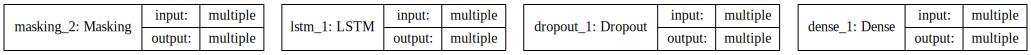

In [148]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Benchmark

